In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import lightgbm as lgb
import gc

Loading Dataset 

In [3]:
df_sub=pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")
df_train=pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
df_test=pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")

Check on Data

In [4]:
df_train.head()

id class  cap-diameter cap-shape cap-surface cap-color  \
0   0     e          8.80         f           s         u   
1   1     p          4.51         x           h         o   
2   2     e          6.94         f           s         b   
3   3     e          3.88         f           y         g   
4   4     e          5.85         x           l         w   

  does-bruise-or-bleed gill-attachment gill-spacing gill-color  ...  \
0                    f               a            c          w  ...   
1                    f               a            c          n  ...   
2                    f               x            c          w  ...   
3                    f               s          NaN          g  ...   
4                    f               d          NaN          w  ...   

   stem-root  stem-surface stem-color veil-type veil-color has-ring ring-type  \
0        NaN           NaN          w       NaN        NaN        f         f   
1        NaN             y          o       NaN        NaN        t         z   
2        NaN             s          n       NaN        NaN        f         f   
3        NaN           NaN          w       NaN        NaN        f         f   
4        NaN           NaN          w       NaN        NaN        f         f   

  spore-print-color habitat season  
0               NaN       d      a  
1               NaN       d      w  
2               NaN       l      w  
3               NaN       d      u  
4               NaN       g      a  

[5 rows x 22 columns]

In [5]:
df_test.head()

id  cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0  3116945          8.64         x         NaN         n                    t   
1  3116946          6.90         o           t         o                    f   
2  3116947          2.00         b           g         n                    f   
3  3116948          3.47         x           t         n                    f   
4  3116949          6.17         x           h         y                    f   

  gill-attachment gill-spacing gill-color  stem-height  ...  stem-root  \
0             NaN          NaN          w        11.13  ...          b   
1             NaN            c          y         1.27  ...        NaN   
2             NaN            c          n         6.18  ...        NaN   
3               s            c          n         4.98  ...        NaN   
4               p          NaN          y         6.73  ...        NaN   

  stem-surface stem-color veil-type veil-color has-ring ring-type  \
0          NaN          w         u          w        t         g   
1          NaN          n       NaN        NaN        f         f   
2          NaN          n       NaN        NaN        f         f   
3          NaN          w       NaN          n        t         z   
4          NaN          y       NaN          y        t       NaN   

  spore-print-color habitat season  
0               NaN       d      a  
1               NaN       d      a  
2               NaN       d      s  
3               NaN       d      u  
4               NaN       d      u  

[5 rows x 21 columns]

In [6]:
df_test.shape,df_train.shape

((2077964, 21), (3116945, 22))

In [7]:
df_train = df_train.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

Checking Distribution of categorical features

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 499.4+ MB


In [9]:
categorical_columns = df_train.select_dtypes(include=['object']).columns
unique_values = {col: df_train[col].nunique() for col in categorical_columns}
for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")
    
gc.collect()

class: 2 unique values
cap-shape: 74 unique values
cap-surface: 83 unique values
cap-color: 78 unique values
does-bruise-or-bleed: 26 unique values
gill-attachment: 78 unique values
gill-spacing: 48 unique values
gill-color: 63 unique values
stem-root: 38 unique values
stem-surface: 60 unique values
stem-color: 59 unique values
veil-type: 22 unique values
veil-color: 24 unique values
has-ring: 23 unique values
ring-type: 40 unique values
spore-print-color: 32 unique values
habitat: 52 unique values
season: 4 unique values


0

In [10]:
categorical_columns = df_test.select_dtypes(include=['object']).columns
unique_values = {col: df_test[col].nunique() for col in categorical_columns}
for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")
    
gc.collect()

cap-shape: 62 unique values
cap-surface: 59 unique values
cap-color: 57 unique values
does-bruise-or-bleed: 22 unique values
gill-attachment: 66 unique values
gill-spacing: 35 unique values
gill-color: 56 unique values
stem-root: 31 unique values
stem-surface: 54 unique values
stem-color: 55 unique values
veil-type: 15 unique values
veil-color: 23 unique values
has-ring: 23 unique values
ring-type: 36 unique values
spore-print-color: 33 unique values
habitat: 39 unique values
season: 4 unique values


0

In [11]:
df_test.columns

Index(['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [12]:
df_train.columns

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

Exploratory Data Analysis(EDA)

In [13]:
import seaborn as sns

In [14]:
missing_train = df_train.isna().mean() * 100
missing_test = df_test.isna().mean() * 100

print("Columns in df_train with more than 10% missing values:")
print(missing_train[missing_train > 0])

print("\nColumns in df_test with more than 10% missing values:")
print(missing_test[missing_test > 0])

Columns in df_train with more than 10% missing values:
cap-diameter             0.000128
cap-shape                0.001283
cap-surface             21.528227
cap-color                0.000385
does-bruise-or-bleed     0.000257
gill-attachment         16.809280
gill-spacing            40.373988
gill-color               0.001829
stem-root               88.452732
stem-surface            63.551362
stem-color               0.001219
veil-type               94.884350
veil-color              87.936970
has-ring                 0.000770
ring-type                4.134818
spore-print-color       91.425482
habitat                  0.001444
dtype: float64

Columns in df_test with more than 10% missing values:
cap-diameter             0.000337
cap-shape                0.001492
cap-surface             21.506821
cap-color                0.000626
does-bruise-or-bleed     0.000481
gill-attachment         16.834796
gill-spacing            40.404694
gill-color               0.002358
stem-height              

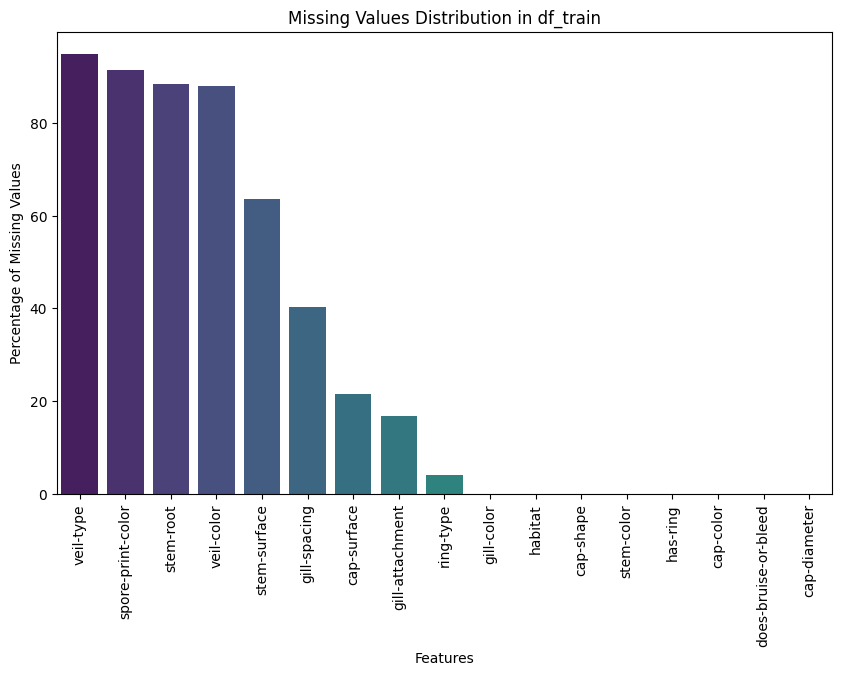

In [15]:
missing_values = df_train.isnull().mean() * 100
missing_values = missing_values[missing_values >0]
missing_values = missing_values.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values Distribution in df_train')
plt.show()

In [16]:
!pip install dython

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import category_encoders as ce

missing_threshold = 0.95

high_missing_columns = df_train.columns[df_train.isnull().mean() > missing_threshold]

df_train = df_train.drop(columns=high_missing_columns)
df_test = df_test.drop(columns=high_missing_columns)
target = 'class'

for column in df_train.columns:
    if df_train[column].isnull().any():      
        if df_train[column].dtype == 'object':
            mode_value = df_train[column].mode()[0]
            df_train[column].fillna(mode_value, inplace=True)
            df_test[column].fillna(mode_value, inplace=True)     
        else:
            median_value = df_train[column].median()
            df_train[column].fillna(median_value, inplace=True)
            df_test[column].fillna(median_value, inplace=True)

/tmp/ipykernel_13/2551056608.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[column].fillna(median_value, inplace=True)
/tmp/ipykernel_13/2551056608.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


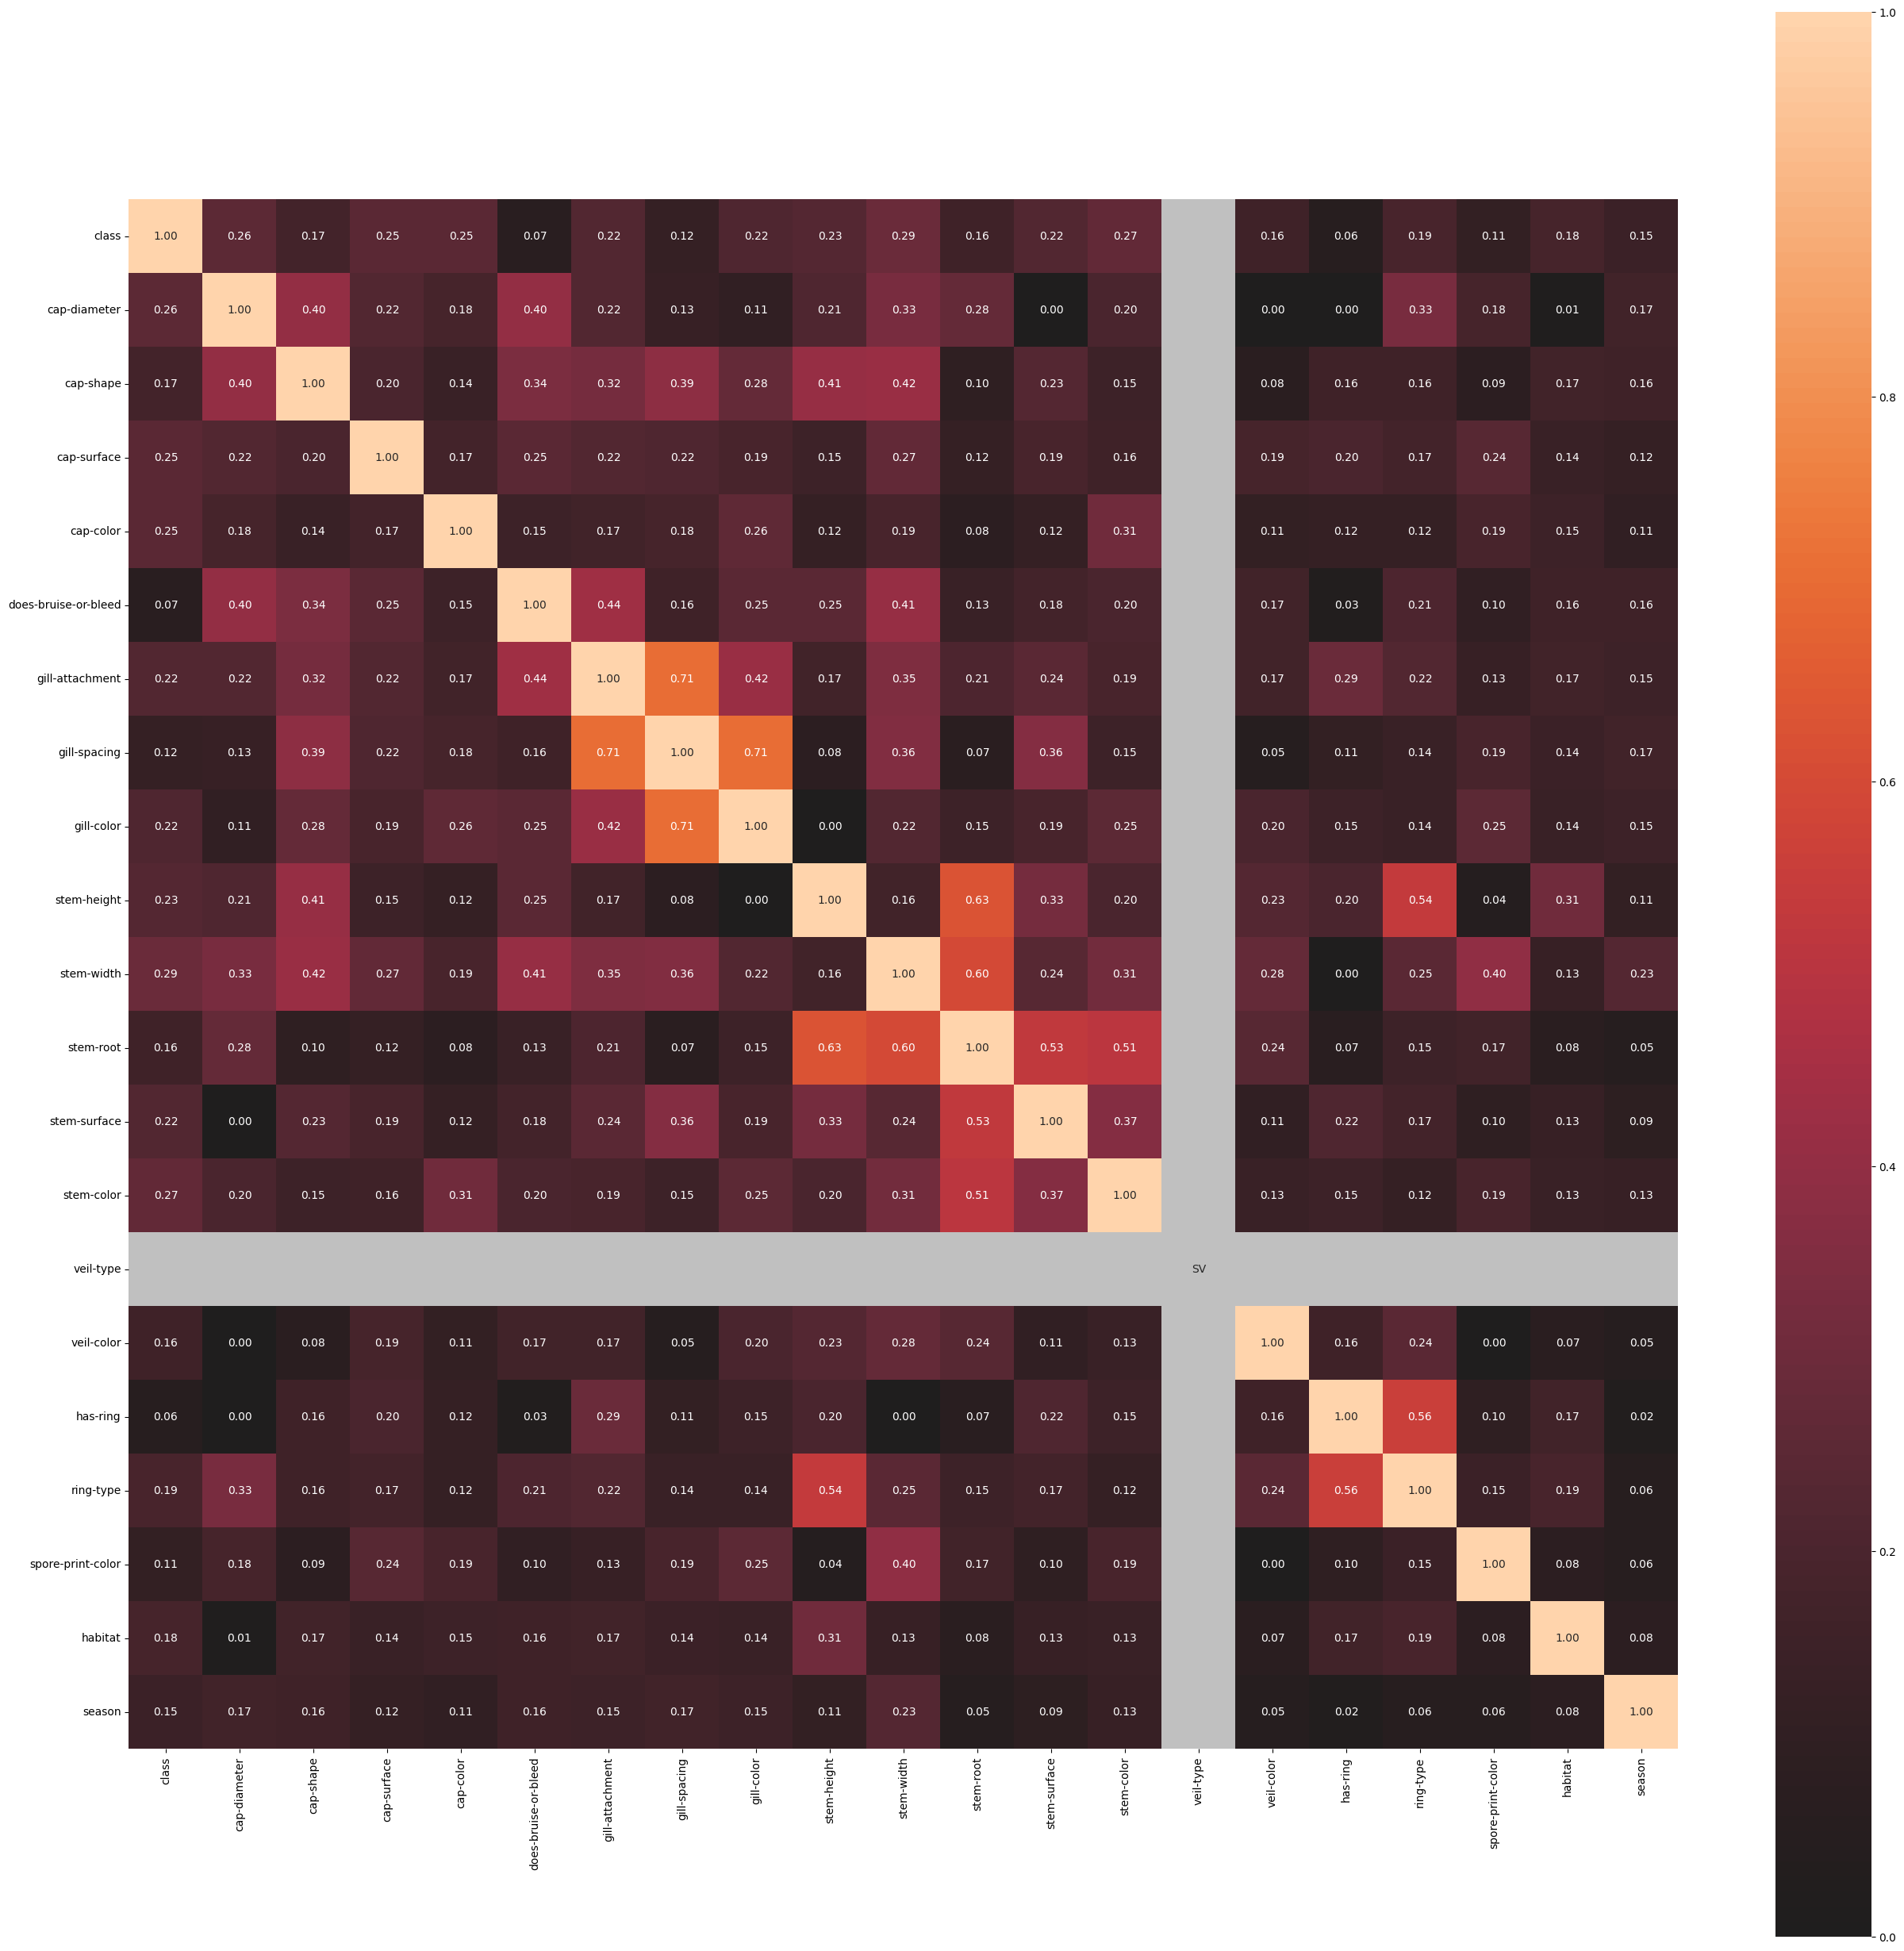

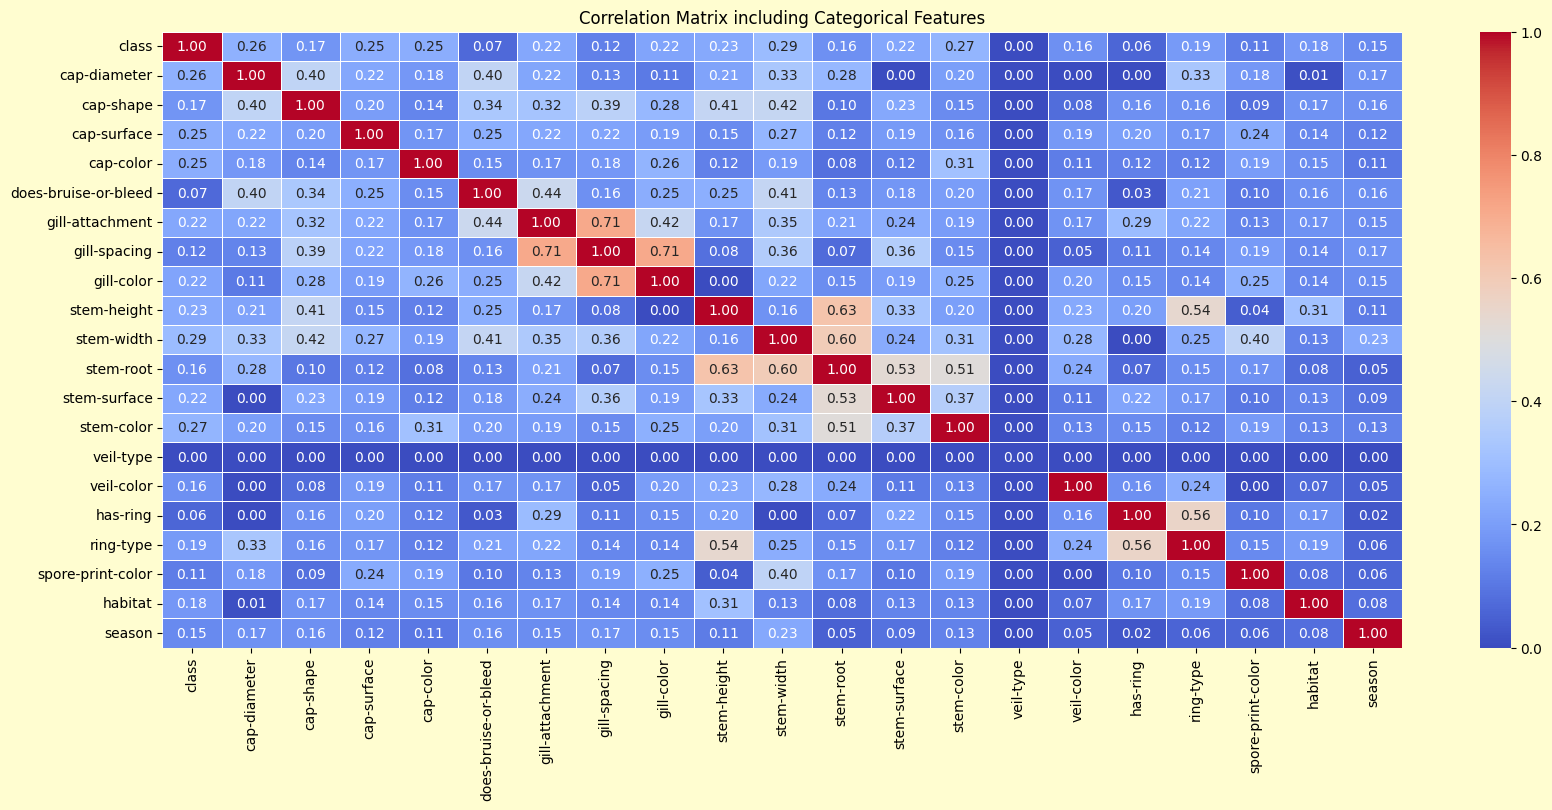

In [18]:
from dython.nominal import associations

associations_df = associations(df_train[:10000], nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']
plt.figure(figsize=(20, 8))
plt.gcf().set_facecolor('#FFFDD0') 
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

In [19]:
import plotly.express as px
df_train1 = df_train[:10000].copy()

feature_counts = df_train1.groupby(['cap-shape', 'cap-color']).size().reset_index(name='count')
fig = px.sunburst(feature_counts, path=['cap-shape', 'cap-color'], values='count',
                 color='count', color_continuous_scale='Viridis',
                 title='Sunburst Chart of Cap Shape and Cap Color Distribution')

fig.update_layout(title_text='Sunburst Chart of Cap Shape and Cap Color Distribution',
                  title_x=0.5,width=900,height=600)  
fig.show()

In [20]:
import plotly.graph_objects as go

flow_data = df_train1.groupby(['cap-shape', 'cap-color']).size().reset_index(name='count')
labels = list(pd.concat([flow_data['cap-shape'], flow_data['cap-color']]).unique())
label_map = {label: idx for idx, label in enumerate(labels)}

sources = flow_data['cap-shape'].map(label_map).tolist()
targets = flow_data['cap-color'].map(label_map).tolist()
values = flow_data['count'].tolist()


fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=labels
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(
    title_text='Sankey Chart of Cap Shape to Cap Color Flow',
    title_x=0.5,  
    width=1000,   
    height=600 
)
fig.show()

In [21]:
feature_counts = df_train1.groupby(['cap-shape', 'cap-color']).size().reset_index(name='count')
fig = px.bar(feature_counts, x='cap-shape', y='count', color='cap-color',
             title='Crosstab Chart of Cap Shape and Cap Color',
             labels={'cap-shape': 'Cap Shape', 'count': 'Count', 'cap-color': 'Cap Color'},
             color_discrete_sequence=px.colors.qualitative.Plotly,
             text='count')  
fig.update_layout(
    title_text='Crosstab Chart of Cap Shape and Cap Color',
    title_x=0.5, 
    xaxis_title='Cap Shape',
    yaxis_title='Count',
    barmode='stack'
)

fig.show()

In [22]:
cols_to_drop_train = missing_train[missing_train > 95].index
cols_to_drop_test = missing_test[missing_test > 95].index

df_train = df_train.drop(columns=cols_to_drop_train)
df_test = df_test.drop(columns=cols_to_drop_test)
gc.collect()

1655

In [23]:
from sklearn.impute import KNNImputer
import pandas as pd

def knn_impute(df, n_neighbors=5):   
    df_encoded = df.copy()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)
    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return df_imputed

In [24]:
df_train_imputed = knn_impute(df_train, n_neighbors=5)
df_test_imputed = knn_impute(df_test, n_neighbors=5)

In [25]:
cat_cols_train = df_train_imputed.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df_train_imputed[cat_cols_train] = ordinal_encoder.fit_transform(df_train_imputed[cat_cols_train].astype(str))
df_test_imputed[cat_cols_train] = ordinal_encoder.transform(df_test_imputed[cat_cols_train].astype(str))

In [26]:
df_train_imputed.head()

class  cap-diameter  cap-shape  cap-surface  cap-color  \
0     e          8.80       53.0         72.0       72.0   
1     p          4.51       71.0         56.0       64.0   
2     e          6.94       53.0         72.0       49.0   
3     e          3.88       53.0         81.0       57.0   
4     e          5.85       71.0         65.0       74.0   

   does-bruise-or-bleed  gill-attachment  gill-spacing  gill-color  \
0                   8.0             44.0          28.0        59.0   
1                   8.0             44.0          28.0        46.0   
2                   8.0             75.0          28.0        59.0   
3                   8.0             70.0          28.0        37.0   
4                   8.0             47.0          28.0        59.0   

   stem-height  ...  stem-root  stem-surface  stem-color  veil-type  \
0         4.51  ...       15.0          51.0        55.0       19.0   
1         4.79  ...       15.0          58.0        47.0       19.0   
2         6.85  ...       15.0          51.0        46.0       19.0   
3         4.16  ...       15.0          51.0        55.0       19.0   
4         3.37  ...       15.0          51.0        55.0       19.0   

   veil-color  has-ring  ring-type  spore-print-color  habitat  season  
0        21.0       5.0       18.0               17.0     25.0     0.0  
1        21.0      18.0       39.0               17.0     25.0     3.0  
2        21.0       5.0       18.0               17.0     36.0     3.0  
3        21.0       5.0       18.0               17.0     25.0     2.0  
4        21.0       5.0       18.0               17.0     29.0     0.0  

[5 rows x 21 columns]

In [27]:
df_test_imputed.head()

cap-diameter  cap-shape  cap-surface  cap-color  does-bruise-or-bleed  \
0          8.64       71.0         76.0       63.0                  20.0   
1          6.90       63.0         76.0       64.0                   8.0   
2          2.00       48.0         55.0       63.0                   8.0   
3          3.47       71.0         76.0       63.0                   8.0   
4          6.17       71.0         56.0       76.0                   8.0   

   gill-attachment  gill-spacing  gill-color  stem-height  stem-width  \
0             44.0          28.0        59.0        11.13       17.12   
1             44.0          28.0        61.0         1.27       10.75   
2             44.0          28.0        46.0         6.18        3.14   
3             70.0          28.0        46.0         4.98        8.51   
4             66.0          28.0        61.0         6.73       13.70   

   stem-root  stem-surface  stem-color  veil-type  veil-color  has-ring  \
0       15.0          51.0        55.0       19.0        21.0      18.0   
1       15.0          51.0        46.0       19.0        21.0       5.0   
2       15.0          51.0        46.0       19.0        21.0       5.0   
3       15.0          51.0        55.0       19.0        14.0      18.0   
4       15.0          51.0        57.0       19.0        22.0      18.0   

   ring-type  spore-print-color  habitat  season  
0       19.0               17.0     25.0     0.0  
1       18.0               17.0     25.0     0.0  
2       18.0               17.0     25.0     1.0  
3       39.0               17.0     25.0     2.0  
4       18.0               17.0     25.0     2.0

In [28]:
df_train = df_train_imputed
df_test = df_test_imputed

In [29]:
df_test.head()

cap-diameter  cap-shape  cap-surface  cap-color  does-bruise-or-bleed  \
0          8.64       71.0         76.0       63.0                  20.0   
1          6.90       63.0         76.0       64.0                   8.0   
2          2.00       48.0         55.0       63.0                   8.0   
3          3.47       71.0         76.0       63.0                   8.0   
4          6.17       71.0         56.0       76.0                   8.0   

   gill-attachment  gill-spacing  gill-color  stem-height  stem-width  \
0             44.0          28.0        59.0        11.13       17.12   
1             44.0          28.0        61.0         1.27       10.75   
2             44.0          28.0        46.0         6.18        3.14   
3             70.0          28.0        46.0         4.98        8.51   
4             66.0          28.0        61.0         6.73       13.70   

   stem-root  stem-surface  stem-color  veil-type  veil-color  has-ring  \
0       15.0          51.0        55.0       19.0        21.0      18.0   
1       15.0          51.0        46.0       19.0        21.0       5.0   
2       15.0          51.0        46.0       19.0        21.0       5.0   
3       15.0          51.0        55.0       19.0        14.0      18.0   
4       15.0          51.0        57.0       19.0        22.0      18.0   

   ring-type  spore-print-color  habitat  season  
0       19.0               17.0     25.0     0.0  
1       18.0               17.0     25.0     0.0  
2       18.0               17.0     25.0     1.0  
3       39.0               17.0     25.0     2.0  
4       18.0               17.0     25.0     2.0

In [30]:
le = LabelEncoder()
df_train['class'] = le.fit_transform(df_train['class'])

In [31]:
y = df_train['class'] 
X = df_train.drop(['class'],axis=1)

Model Building | Training | Classification

In [32]:
train_X, test_X, train_y, test_y = train_test_split(X, y,test_size = 0.2, random_state =42,stratify=y)

Classification Analysis

In [33]:
from sklearn.metrics import matthews_corrcoef

In [34]:
def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

In [35]:
from sklearn.metrics import matthews_corrcoef
from xgboost import XGBClassifier

model = XGBClassifier(                    
    alpha=0.1,                   
    subsample=0.8,     
    colsample_bytree=0.6,  
    objective='binary:logistic',
    max_depth=14,             
    min_child_weight=7,         
    gamma=1e-6,                
    #random_state=42,                 
    n_estimators=100
    )

XGB = model.fit(
    train_X, 
    train_y, 
    eval_set=[(test_X, test_y)],
    eval_metric=mcc_metric)

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-logloss:0.45738	validation_0-mcc:0.94268
[1]	validation_0-logloss:0.33765	validation_0-mcc:0.96124
[2]	validation_0-logloss:0.26580	validation_0-mcc:0.96739
[3]	validation_0-logloss:0.21367	validation_0-mcc:0.96967
[4]	validation_0-logloss:0.17504	validation_0-mcc:0.97117
[5]	validation_0-logloss:0.14098	validation_0-mcc:0.97336
[6]	validation_0-logloss:0.11705	validation_0-mcc:0.97564
[7]	validation_0-logloss:0.09544	validation_0-mcc:0.97770
[8]	validation_0-logloss:0.08257	validation_0-mcc:0.97800
[9]	validation_0-logloss:0.07233	validation_0-mcc:0.97855
[10]	validation_0-logloss:0.06369	validation_0-mcc:0.97942
[11]	validation_0-logloss:0.05977	validation_0-mcc:0.97957
[12]	validation_0-logloss:0.05483	validation_0-mcc:0.97970
[13]	validation_0-logloss:0.05190	validation_0-mcc:0.97984
[14]	validation_0-logloss:0.04799	validation_0-mcc:0.98073
[15]	validation_0-logloss:0.04680	validation_0-mcc:0.98077
[16]	validation_0-logloss:0.04497	validation_0-mcc:0.98112
[17]	va

In [36]:
y_pred = XGB.predict(test_X)

In [37]:
import lime
import lime.lime_tabular

In [38]:
redict_fn_xgb = lambda x: XGB.predict_proba(x).astype(float)
X = train_X.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names = train_X.columns,class_names=['Poisnous','edible'],kernel_width=5)

In [39]:
df_test.head(4)

cap-diameter  cap-shape  cap-surface  cap-color  does-bruise-or-bleed  \
0          8.64       71.0         76.0       63.0                  20.0   
1          6.90       63.0         76.0       64.0                   8.0   
2          2.00       48.0         55.0       63.0                   8.0   
3          3.47       71.0         76.0       63.0                   8.0   

   gill-attachment  gill-spacing  gill-color  stem-height  stem-width  \
0             44.0          28.0        59.0        11.13       17.12   
1             44.0          28.0        61.0         1.27       10.75   
2             44.0          28.0        46.0         6.18        3.14   
3             70.0          28.0        46.0         4.98        8.51   

   stem-root  stem-surface  stem-color  veil-type  veil-color  has-ring  \
0       15.0          51.0        55.0       19.0        21.0      18.0   
1       15.0          51.0        46.0       19.0        21.0       5.0   
2       15.0          51.0        46.0       19.0        21.0       5.0   
3       15.0          51.0        55.0       19.0        14.0      18.0   

   ring-type  spore-print-color  habitat  season  
0       19.0               17.0     25.0     0.0  
1       18.0               17.0     25.0     0.0  
2       18.0               17.0     25.0     1.0  
3       39.0               17.0     25.0     2.0

In [40]:
df_test.loc[[3]]

cap-diameter  cap-shape  cap-surface  cap-color  does-bruise-or-bleed  \
3          3.47       71.0         76.0       63.0                   8.0   

   gill-attachment  gill-spacing  gill-color  stem-height  stem-width  \
3             70.0          28.0        46.0         4.98        8.51   

   stem-root  stem-surface  stem-color  veil-type  veil-color  has-ring  \
3       15.0          51.0        55.0       19.0        14.0      18.0   

   ring-type  spore-print-color  habitat  season  
3       39.0               17.0     25.0     2.0

In [41]:
test_X

cap-diameter  cap-shape  cap-surface  cap-color  \
1745452          4.00       53.0         76.0       63.0   
288331           9.30       63.0         76.0       63.0   
421615           8.74       53.0         76.0       74.0   
2794259          3.75       67.0         47.0       57.0   
78948           15.30       67.0         76.0       60.0   
...               ...        ...          ...        ...   
1584520          5.57       48.0         56.0       60.0   
2921070          5.62       53.0         81.0       63.0   
2053944          6.23       53.0         81.0       63.0   
44159            7.30       71.0         76.0       57.0   
2244255          7.20       53.0         76.0       63.0   

         does-bruise-or-bleed  gill-attachment  gill-spacing  gill-color  \
1745452                   8.0             44.0          31.0        61.0   
288331                    8.0             44.0          28.0        59.0   
421615                    8.0             47.0          28.0        61.0   
2794259                  20.0             47.0          28.0        48.0   
78948                     8.0             44.0          31.0        61.0   
...                       ...              ...           ...         ...   
1584520                   8.0             70.0          31.0        59.0   
2921070                   8.0             70.0          28.0        37.0   
2053944                   8.0             52.0          28.0        48.0   
44159                    20.0             66.0          28.0        59.0   
2244255                   8.0             47.0          28.0        61.0   

         stem-height  stem-width  stem-root  stem-surface  stem-color  \
1745452         7.55        7.06       15.0          44.0        47.0   
288331          5.00       26.53       15.0          51.0        46.0   
421615          2.72       18.36       15.0          51.0        55.0   
2794259         4.27        5.97       15.0          51.0        38.0   
78948           4.83       22.90       15.0          51.0        55.0   
...              ...         ...        ...           ...         ...   
1584520         5.56       11.97       15.0          51.0        38.0   
2921070         5.08        8.44       15.0          51.0        55.0   
2053944         3.63       11.73       15.0          51.0        55.0   
44159          11.47       26.34       15.0          58.0        55.0   
2244255         6.36        9.75       15.0          51.0        46.0   

         veil-type  veil-color  has-ring  ring-type  spore-print-color  \
1745452       19.0        21.0       5.0       18.0               17.0   
288331        19.0        21.0       5.0       18.0               17.0   
421615        19.0        21.0       5.0       18.0               17.0   
2794259       19.0        21.0       5.0       18.0               17.0   
78948         19.0        21.0       5.0       18.0               29.0   
...            ...         ...       ...        ...                ...   
1584520       19.0        21.0       5.0       18.0               17.0   
2921070       19.0        21.0       5.0       18.0               17.0   
2053944       19.0        21.0      18.0       23.0               17.0   
44159         19.0        21.0       5.0       18.0               17.0   
2244255       19.0        21.0       5.0       18.0               17.0   

         habitat  season  
1745452     25.0     1.0  
288331      25.0     2.0  
421615      25.0     3.0  
2794259     25.0     2.0  
78948       25.0     2.0  
...          ...     ...  
1584520     25.0     0.0  
2921070     25.0     0.0  
2053944     48.0     0.0  
44159       25.0     2.0  
2244255     36.0     0.0  

[623389 rows x 20 columns]

In [42]:
choosen_instance = test_X.loc[[1584520]].values[0]
exp = explainer.explain_instance(choosen_instance, redict_fn_xgb,num_features=15)
exp.show_in_notebook(show_all=False)

In [43]:
choosen_instance = test_X.loc[[2244255]].values[0]
exp = explainer.explain_instance(choosen_instance, redict_fn_xgb,num_features=15)
exp.show_in_notebook(show_all=False)

In [44]:
choosen_instance = test_X.loc[[421615]].values[0]
exp = explainer.explain_instance(choosen_instance, redict_fn_xgb,num_features=15)
exp.show_in_notebook(show_all=False)

In [45]:
choosen_instance = test_X.loc[[2921070]].values[0]
exp = explainer.explain_instance(choosen_instance, redict_fn_xgb,num_features=15)
exp.show_in_notebook(show_all=False)

In [46]:
choosen_instance = test_X.loc[[44159]].values[0]
exp = explainer.explain_instance(choosen_instance, redict_fn_xgb,num_features=15)
exp.show_in_notebook(show_all=False)

In [47]:
score = matthews_corrcoef(test_y, y_pred)
print('MCC:', score)

MCC: 0.9828138758049558


In [48]:
test_pred_prob = XGB.predict(df_test)

In [49]:
test_pred_prob

array([0, 1, 1, ..., 1, 0, 0])

In [50]:
test_pred_class = le.inverse_transform(test_pred_prob)

In [51]:
df_sub['class']= test_pred_class

Final Submission

In [52]:
df_sub.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')

id class
0        3116945     e
1        3116946     p
2        3116947     p
3        3116948     p
4        3116949     e
...          ...   ...
2077959  5194904     p
2077960  5194905     p
2077961  5194906     p
2077962  5194907     e
2077963  5194908     e

[2077964 rows x 2 columns]

<Axes: >

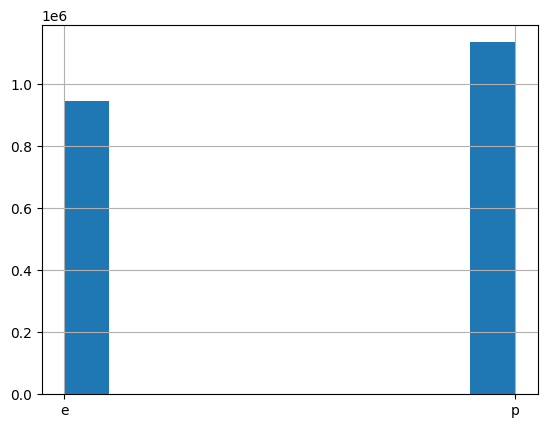

In [53]:
df_sub['class'].hist()